### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 2

**Student Name:**    `TANZID SULTAN`

**Student ID:**     `1430660`

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [3]:
# library imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# make sure GPU is available
print(tf.config.list_physical_devices('GPU'))


2023-09-06 05:10:44.720990: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 05:10:44.774503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 05:10:45.407962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-06 05:10:46.373836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 05:10:46.451995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 05:10:46.452837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:

data_dir = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 20

# Data generator for training
# Additional data augmentation may be added here if desired
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #horizontal_flip=True,                    # flip horizontally
    #rotation_range=15,                       # random rotations 
    width_shift_range=0.3,                   # random horizontal translations (***)
    height_shift_range=0.3,                  # random vertical translations (***)
    zoom_range=0.5,                          # random zooming
    #shear_range=0.3,                         # random shearing  
    #brightness_range=[0.25, 1.25],             # randomly adjust the brightness between 0.5 and 1.5
    #channel_shift_range=50,
    #zca_whitening=True,
    fill_mode='wrap'#'nearest' 
    )

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
    rescale=1./255)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1)

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir+'/valid',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1)

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir+'/test',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)

# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


#### CNN model according to specs

In [5]:
# build the model
lr = 0.0008 #0.00005  # 0.001 defaul
initializer1 = tf.keras.initializers.GlorotNormal(seed=1)
initializer2 = tf.keras.initializers.GlorotNormal(seed=2)
initializer3 = tf.keras.initializers.GlorotNormal(seed=3)
initializer4 = tf.keras.initializers.GlorotNormal(seed=4)
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr,decay_steps=100,decay_rate=0.95,staircase=True)

cnn1 = keras.Sequential(
    [
        layers.Input((32,32,3)),                                       # input image shape is 32x32x3  
        layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_initializer=initializer1),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_initializer=initializer2),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
        layers.Flatten(),                                              # unravel the 3d tensor from the previous layer output
        #layers.Dropout(0.1),
        layers.Dense(64, activation='relu', kernel_initializer=initializer3),
        #layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(8, activation='softmax', kernel_initializer=initializer4)                          # output layer with 8 neurons, corresponding to the 8 categories
    ]
)


# configure the model
cnn1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# display summary
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                        

2023-09-06 05:10:47.886941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 05:10:47.887520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 05:10:47.888051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 05:10:48.727784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 05:10:48.728805: I tensorflow/compile

In [6]:
# train the model again, this time with augmented images
history_cnn1_aug = cnn1.fit(train_data, validation_data=val_data, epochs=250, verbose=2) 

# plot some learning curves
def plot_graphs(training_history, metric):
    plt.plot(training_history.history[metric])
    plt.plot(training_history.history["val_"+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["training_"+metric, "val_"+metric])
    plt.show()

plot_graphs(history_cnn1_aug, "accuracy")
plot_graphs(history_cnn1_aug, "loss")

# Evaluate model performance on the test data
test_results = cnn1.evaluate(test_data)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

Epoch 1/250


2023-09-06 05:10:56.210321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-06 05:10:58.491154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-06 05:11:00.055708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-06 05:11:00.063274: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6ba00162a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-06 05:11:00.063309: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-09-06 05:

### 2. Error anaylsis

In [271]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [272]:
test_images, test_labels = [], []
n_batches = int(np.ceil(test_data.n/test_data.batch_size))
for i in range(n_batches):
    x_batch, y_batch = next(test_data)
    #print(f"x_batch shape: {x_batch.shape}")
    #print(f"y_batch shape: {y_batch.shape}")
    test_images.append(x_batch)
    test_labels.append(y_batch)

test_images = np.concatenate(test_images, axis=0)    
test_labels = np.concatenate(test_labels, axis=0)
print(f"Test images shape: {test_images.shape}")    
print(f"Test labels shape: {test_labels.shape}")    

Test images shape: (320, 32, 32, 3)
Test labels shape: (320, 8)


10/10 [==============================] - 0s 3ms/step
y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Class: coast, Number of correct predictions: 28, Accuracy: 0.7
y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
y_preds: [4 2 0 0 0 0 0 4 0 0 4 0 0 0 0 0 0 0 0 0 0 4 0 2 2 0 2 2 0 0 0 0 5 0 4 0 2
 0 0 0]
Class: forest, Number of correct predictions: 34, Acc

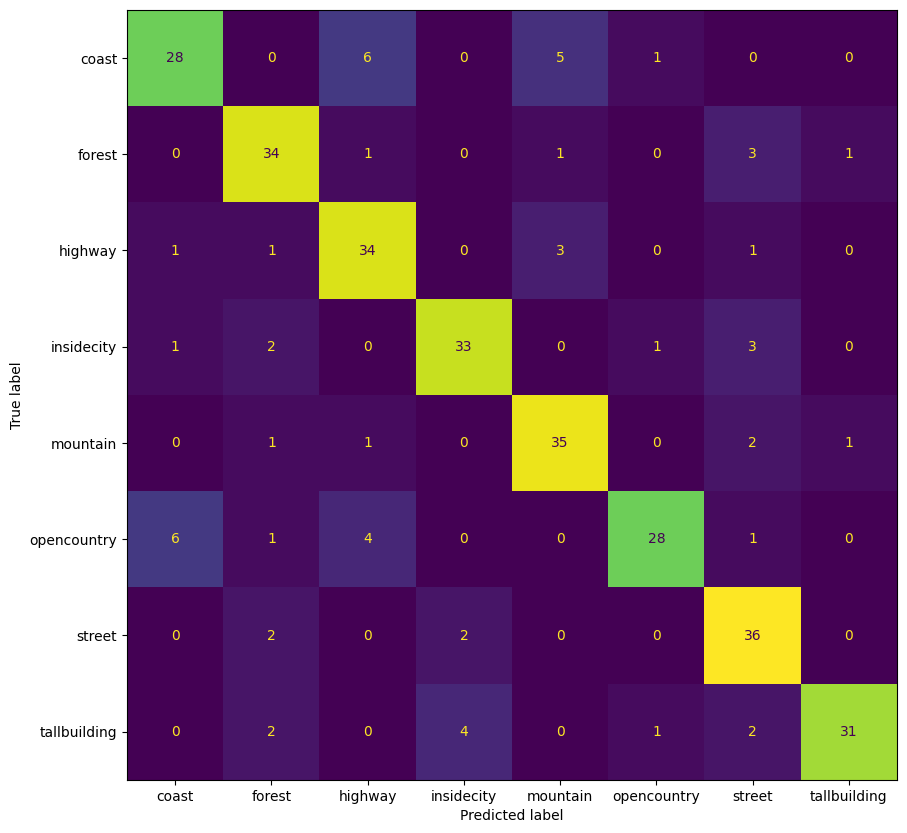

In [273]:
# compute predicted labels for test data
y_preds = np.argmax(cnn1.predict(test_images), axis=1) 

# actual labels
y = np.argmax(test_labels, axis=1) 
print(f"y: {y}")


n_class = 8
n_img_per_class = 40 

class_names = {c_index : c_name for (c_name, c_index) in class_names_and_indices.items()}
n_correct_tot = 0

# compute accuracy per class
for i in range(n_class):
    y_compare = np.equal(y_preds[i*n_img_per_class : (i+1)*n_img_per_class], y[i*n_img_per_class : (i+1)*n_img_per_class])
    n_correct = np.sum(y_compare)
    n_correct_tot += n_correct
    print(f"Class: {class_names[i]}, Number of correct predictions: {n_correct}, Accuracy: {n_correct/n_img_per_class}")
    print(f"y: {y[i*n_img_per_class : (i+1)*n_img_per_class]}")
    print(f"y_preds: {y_preds[i*n_img_per_class : (i+1)*n_img_per_class]}")
    
print(f"Overall classification accuracy for test data: {n_correct_tot/(n_class * n_img_per_class)}")

cm = confusion_matrix(y, y_preds)

disp = ConfusionMatrixDisplay.from_predictions(y, y_preds, display_labels= class_names_and_indices.keys(), colorbar=False)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
#fig.suptitle('Confusion matrix')


#### It is useful to plot a confusin matrix so that we can see if there are any obvious patterns in how the model misclassifies images from certain classes.

#### It looks like 'Highway' and 'street' images are frequently miscalssified as being 'insidecity', not too surprising as these classes share lots of similarities. 'Coast' gets frequently misclassified as 'highway'. A sizable number of 'mountain' images are misclassified as 'tallbuilding'. 'Forest' is also misclassified as 'insidecity' and 'tallbuilding'.

#### We can also take a closer look at some of the misclassified images

### 3. Kernel engineering

#### CNN Model with only one Conv layer

In [ ]:
# kernel size
k = 3

In [ ]:
# build the model
cnn2 = keras.Sequential(
    [
        layers.Input((32,32,3)),                                       # input image shape is 32x32x3  
        layers.Conv2D(16, (k,k), padding='valid', activation='relu'),
        layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
        layers.Flatten(),                                              # unravel the 3d tensor from the previous layer output
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')                          # output layer with 8 neurons, corresponding to the 8 categories
    ]
)


# configure the model
cnn2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# display summary
cnn2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 3600)              0         
                                                                 
 dropout_16 (Dropout)        (None, 3600)              0         
                                                                 
 dense_46 (Dense)            (None, 64)                230464    
                                                                 
 dense_47 (Dense)            (None, 8)                 520       
                                                     

In [ ]:
# train the model again, this time with augmented images
history_cnn2 = cnn2.fit(train_data, validation_data=val_data, epochs=800, verbose=2) 

Epoch 1/800


2023-09-02 01:05:30.072170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 - 1s - loss: 2.0772 - accuracy: 0.1597 - val_loss: 2.0529 - val_accuracy: 0.1937 - 1s/epoch - 93ms/step
Epoch 2/800


2023-09-02 01:05:31.351512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 - 1s - loss: 2.0387 - accuracy: 0.2146 - val_loss: 2.0120 - val_accuracy: 0.2906 - 564ms/epoch - 38ms/step
Epoch 3/800
15/15 - 1s - loss: 1.9984 - accuracy: 0.2493 - val_loss: 1.9601 - val_accuracy: 0.3313 - 540ms/epoch - 36ms/step
Epoch 4/800
15/15 - 1s - loss: 1.9482 - accuracy: 0.2972 - val_loss: 1.9068 - val_accuracy: 0.3844 - 516ms/epoch - 34ms/step
Epoch 5/800
15/15 - 1s - loss: 1.8981 - accuracy: 0.3319 - val_loss: 1.8551 - val_accuracy: 0.4531 - 516ms/epoch - 34ms/step
Epoch 6/800
15/15 - 1s - loss: 1.8478 - accuracy: 0.3889 - val_loss: 1.8007 - val_accuracy: 0.4062 - 524ms/epoch - 35ms/step
Epoch 7/800
15/15 - 1s - loss: 1.8030 - accuracy: 0.4146 - val_loss: 1.7507 - val_accuracy: 0.4781 - 527ms/epoch - 35ms/step
Epoch 8/800
15/15 - 1s - loss: 1.7594 - accuracy: 0.4326 - val_loss: 1.7061 - val_accuracy: 0.4750 - 500ms/epoch - 33ms/step
Epoch 9/800
15/15 - 1s - loss: 1.7157 - accuracy: 0.4326 - val_loss: 1.6640 - val_accuracy: 0.5000 - 531ms/epoch - 35ms/step
Epoch 10/800

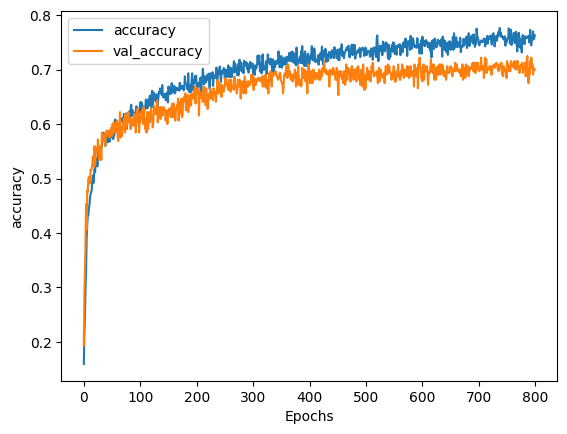

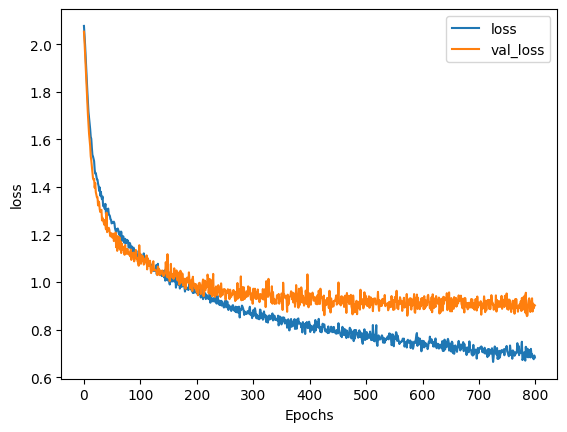

In [ ]:
plot_graphs(history_cnn2, "accuracy")
plot_graphs(history_cnn2, "loss")

In [ ]:
# Evaluate model performance on the test data
test_results = cnn2.evaluate(test_data)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

4/4 [==============================] - 0s 26ms/step - loss: 0.7171 - accuracy: 0.7656
Test results - Loss: 0.7171003818511963 - Accuracy: 0.765625%


2023-09-02 07:41:01.297782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


#### Retrieve the kernels from the Conv2d layer

In [ ]:
# get filter weights
filters, biases = cnn2.layers[0].get_weights()

# normalize the values to be in [0,1] for visualization purposes
f_min , f_max = filters.min(), filters.max()
filters = (filters-f_min) / (f_max- f_min)

#### Visualizing the kernels 

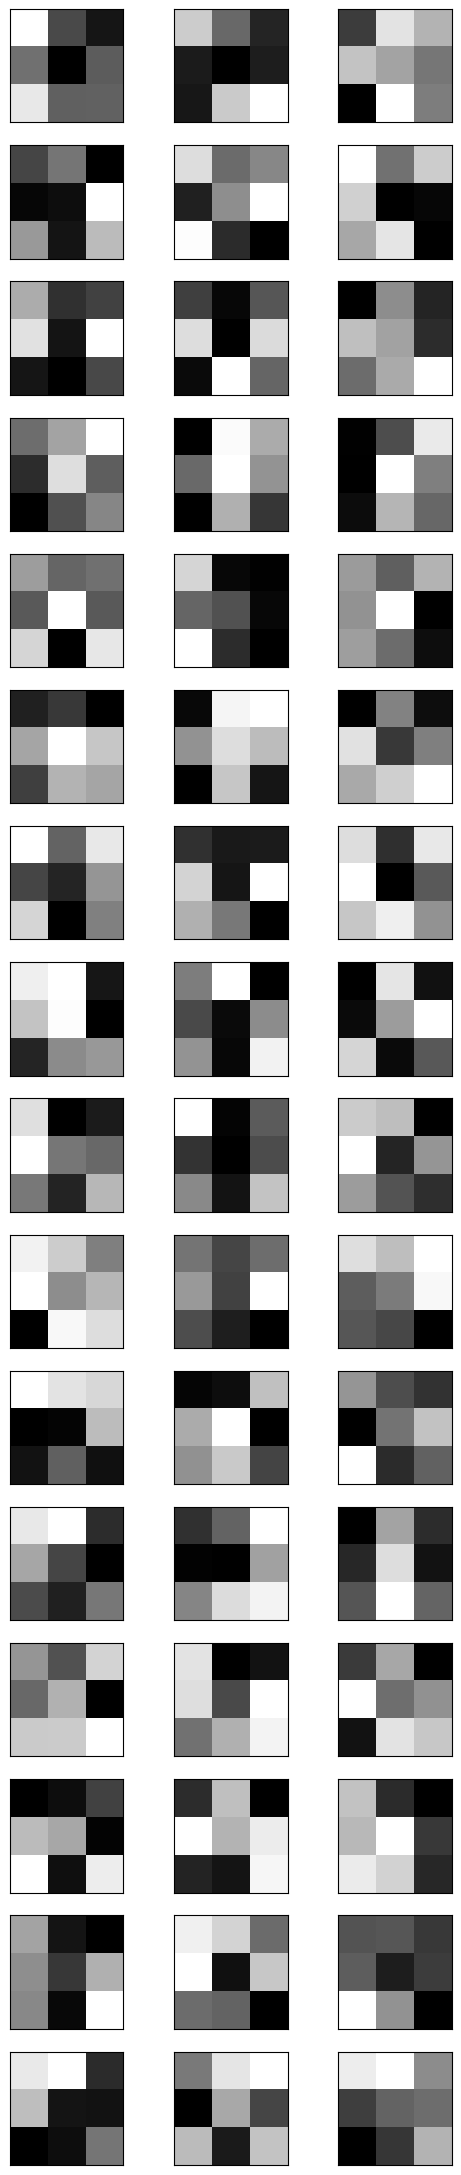

In [ ]:
fig = plt.figure(figsize=(6, 28))
ix =  1

for i in range(16):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # subplot for 6 filters and 3 channels
        # specify subplot and turn of axis
        ax = plt.subplot(16, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# plot the filters
plt.show()